状态价值函数:

V(state) = 所有动作求和 -> 概率(action) * Q(state,action)

对这个式子做变形得到:

V(state) = 所有动作求和 -> 现概率(action) * [旧概率(action) / 现概率(action)] * Q(state,action)

初始时可以认为现概率和旧概率相等,但随着模型的更新,现概率会变化.

式子中的Q(state,action)可以用蒙特卡洛法估计.

按照策略梯度的理论,状态价值取决于动作的质量,所以只要最大化V函数,就可以得到最好的动作策略.

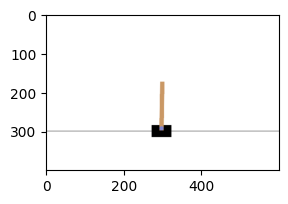

In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True

        #没坚持到最后,扣分
        if over and self.step_n < 200:
            reward = -1000

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()


In [ ]:
import torch

#定义模型
model_action = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
    torch.nn.Softmax(dim=1),
)

model_value = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

model_action(torch.randn(2, 4)), model_value(torch.randn(2, 4))



'''
  高中生版本解說

  這個 Cell 在做的事情是「創造兩個大腦」，一個用來「做決定」，另一個用來「打分數」。這就是 Actor-Critic (演員-評論家) 模式。

   1. `model_action` (演員 / 決策腦):
       * 功能：這是負責實際操作的「演員」。它觀察遊戲的當前狀態（一個包含 4 個數字的列表，描述車和杆子的位置、速度等），然後輸出一個決策。
       * 輸出：它的輸出是兩個數字，代表「向左走的機率」和「向右走的機率」。例如，它可能會輸出 [0.7, 0.3]，意思是「我有 70% 的把握應該向左，30%
         的把握應該向右」。最後的 Softmax 確保了這兩個機率加起來剛好等於 1。

   2. `model_value` (評論家 / 評分腦):
       * 功能：這是負責在旁邊觀看和評價的「評論家」。它也觀察同樣的遊戲狀態。
       * 輸出：它只輸出一個數字。這個數字代表了它對當前局勢的評分，即「狀態價值 (State Value)」。如果分數很高，代表評論家認為「現在這個局面很
         好，未來很有可能獲得高分」。如果分數很低，則代表「現在情況不妙，未來可能會輸」。


  最後一行程式碼 model_action(...) 和 model_value(...) 只是在測試一下，確保我們創造的這兩個大腦的輸入和輸出格式都沒問題。

  簡單來說，我們讓一個大腦專心學習「如何行動」，另一個大腦專心學習「如何判斷局勢」，然後讓它們合作來玩遊戲。

  專業術語解說

  這個 Cell 定義了 PPO 演算法所需的兩個核心神經網路：策略網路 (Actor) 和價值網路 (Critic)。

   1. `model_action` (Actor - 策略網路 $\pi_\theta(a|s)$):
       * 架構: 這是一個標準的多層感知機 (MLP)。它使用 torch.nn.Sequential 容器來搭建。
       * 輸入: 狀態 (state)，維度為 4。
       * 輸出: 一個維度為 2 的向量，代表了在該狀態下，對應兩個離散動作（0: 向左, 1: 向右）的機率分佈。
       * `Softmax` 激活函數: 輸出層之後的 Softmax 層是至關重要的。它將網路輸出的原始分數 (logits)
         轉換成一個合法的機率分佈（所有元素非負，且總和為 1）。這個機率分佈後續將被用來創建一個 Categorical 分佈對象，以便從中採樣動作。

   2. `model_value` (Critic - 價值網路 $V_\phi(s)$):
       * 架構: 同樣是一個 MLP，其隱藏層結構與 Actor 非常相似。
       * 輸入: 狀態 (state)，維度為 4。
       * 輸出: 一個純量的、無界的值。這個值是對輸入狀態 s 的價值（Value）的估計，即
         $V(s)$。它預測了從當前狀態開始，遵循當前策略，未來能夠獲得的總折扣獎勵的期望值。
       * 線性輸出層: 注意，價值網路的輸出層 torch.nn.Linear(64, 1)
         後面沒有激活函數。這是因為價值函數的取值範圍是沒有限制的（可以是任何正數或負數），所以我們需要一個線性的輸出層。

  這種將 Actor 和 Critic 分別用獨立的網路來實現的架構是 Actor-Critic 方法的常見做法。雖然它們的輸入相同，但它們的學習目標和輸出截然不同。
  '''

(tensor([[0.5005, 0.4995],
         [0.4786, 0.5214]], grad_fn=<SoftmaxBackward0>),
 tensor([[0.0713],
         [0.2155]], grad_fn=<AddmmBackward0>))

In [ ]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    state = []
    action = []
    reward = []
    next_state = []
    over = []

    s = env.reset()
    o = False
    while not o:
        #根据概率采样
        prob = model_action(torch.FloatTensor(s).reshape(1, 4))[0].tolist()
        a = random.choices(range(2), weights=prob, k=1)[0]

        ns, r, o = env.step(a)

        state.append(s)
        action.append(a)
        reward.append(r)
        next_state.append(ns)
        over.append(o)

        s = ns

        if show:
            display.clear_output(wait=True)
            env.show()

    state = torch.FloatTensor(state).reshape(-1, 4)
    action = torch.LongTensor(action).reshape(-1, 1)
    reward = torch.FloatTensor(reward).reshape(-1, 1)
    next_state = torch.FloatTensor(next_state).reshape(-1, 4)
    over = torch.LongTensor(over).reshape(-1, 1)

    return state, action, reward, next_state, over, reward.sum().item()


state, action, reward, next_state, over, reward_sum = play()

reward_sum

'''
  高中生版本解說

  這個 Cell 的作用就像一個「遊戲記錄員」。它定義了一個 play 函數，讓我們先前創建的「演員大腦
  (model_action)」去實際玩一局平衡車遊戲，並把整個過程詳細地記錄下來。

   1. 開始遊戲：遊戲從頭開始 (env.reset())。
   2. 重複決策直到遊戲結束：
       * 記錄員把當前情況（狀態 s）給演員大腦看。
       * 演員大腦給出它的建議，比如 [0.7, 0.3]（70%機率向左，30%機率向右）。
       * 記錄員不一定會選擇機率最高的那個，而是像「抽獎」一樣，根據這個機率分佈來隨機選擇一個動作
         a。這很重要，因為這樣能讓演員偶爾嘗試一些不那麼有信心的動作，可能會發現新大陸（這叫「探索」）。
       * 記錄員把選好的動作 a 告訴遊戲，遊戲更新到下一個狀態 ns，並給出得分 r。
       * 記錄員把這一步的所有信息（當前狀態，執行的動作，得分，下一個狀態，遊戲是否結束）全都記在小本本上。
   3. 整理報告：一局遊戲結束後，記錄員會把小本本上的所有數據整理成一個整齊的表格（PyTorch Tensors），方便後續的「教練（訓練函數）」進行分析。
   4. 返回結果：最後，play 函數返回這份詳細的「遊戲報告」以及這一局的總得分。

  最後兩行程式碼就是實際執行了一次 play 函數，並把這一局的總分顯示出來。

  專業術語解說

  這個 Cell 實現了強化學習中的數據收集 (Data Collection) 或 軌跡展開 (Trajectory Rollout) 階段。play 函數的核心職責是使用當前的策略
  $\pi_\theta$（由 `model_action` 參數化）與環境互動，並收集一個完整的回合 (Episode) 的數據。

   1. 策略執行:
       * prob = model_action(...): 將當前狀態 s 輸入策略網路，得到動作的機率分佈。
       * a = random.choices(...): 根據策略網路輸出的機率分佈，隨機採樣一個動作 a。這是執行一個隨機策略 (Stochastic Policy)
         的標準方式。它確保了 Agent 在探索 (Exploration) 和利用 (Exploitation) 之間取得平衡。

   2. 數據存儲: 函數將每一步的轉移元組 $(s_t, a_t, r_t, s_{t+1}, d_t)$（狀態, 動作, 獎勵, 下一狀態, 結束標誌）都存儲在 Python 列表中。

   3. 數據批處理 (Batching):
       * 在回合結束後，所有存儲在列表中的數據都被轉換為 PyTorch Tensor。
       * reshape(-1, ...) 是一個關鍵操作，它將單步的數據組合成一個批次 (Batch)。例如，state 從一個包含多個 (4,) 陣列的列表，變成一個形狀為 [N,
         4] 的張量，其中 N 是這個回合的總步數。
       * 將數據轉換為批次張量，是為了利用 PyTorch 進行高效的向量化計算，這比在 Python 中用 for 迴圈處理每一步數據要快得多。

   4. On-Policy 數據: play 函數返回的這一整套數據，是嚴格遵循當前策略 $\pi_\theta$ 產生的，因此被稱為 On-Policy 數據。PPO
      演算法將使用這些數據來同時更新策略網路和價值網路。

'''


d:\it_project\github_sync\ml-workshop\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\User\AppData\Local\Temp\ipykernel_32392\1112667714.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor(state).reshape(-1, 4)


-983.0

In [ ]:
optimizer_action = torch.optim.Adam(model_action.parameters(), lr=1e-3)
optimizer_value = torch.optim.Adam(model_value.parameters(), lr=1e-2)


def requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad_(value)



'''
requires_grad 是一種「全局開關」，直接告訴 PyTorch：「接下來，請完全忽略這個模型的所有梯度計算」。

  讓我們來看看幾種常見的替代寫法，以及它們的優劣。

  ---

  替代方案 1：使用 torch.no_grad() 上下文管理器 (最常見)

  這是 PyTorch 中最慣用 (idiomatic)、最常見的寫法。

  寫法：
  在 train_value 函數中，計算 target 的部分已經用到了：

   1 # 在 with torch.no_grad() 這個區塊內的所有計算，都不會被追蹤梯度
   2 with torch.no_grad():
   3     target = model_value(next_state)
  如何替代 `requires_grad`：
  我們可以擴大 no_grad 的使用範圍。當我們在訓練 model_value 時，任何涉及到 model_action 的計算（如果有的話）都可以被包裹在 with
  torch.no_grad(): 中。

  優點：
   * 可讀性好：程式碼意圖非常清晰，讀者能一眼看出哪一段程式碼是不需要計算梯度的。
   * 作用域明確：只在 with 區塊內生效，離開區塊後自動恢復，不容易出錯。

  缺點：
   * 如果一個函數裡有多處需要關閉梯度，可能會需要寫好幾個 with 區塊。

'''



In [ ]:
def train_value(state, reward, next_state, over):
    requires_grad(model_action, False)
    requires_grad(model_value, True)

    #计算target
    with torch.no_grad():
        target = model_value(next_state)
    target = target * 0.98 * (1 - over) + reward

    #每批数据反复训练10次
    for _ in range(10):
        #计算value
        value = model_value(state)

        loss = torch.nn.functional.mse_loss(value, target)
        loss.backward()
        optimizer_value.step()
        optimizer_value.zero_grad()

    #减去value相当于去基线
    return (target - value).detach()


value = train_value(state, reward, next_state, over)

value.shape


'''
高中生版本解說

  這個函數的目標是訓練我們的「評論家大腦 (`model_value`)」，讓它的打分越來越準。同時，它還會計算一個副產品，叫做「優勢
  (Advantage)」，給下一個函數使用。

   1. 計算「標準答案 (`target`)」：
       * 評論家大腦的學習方式是「對答案」。所以我們首先要算出「標準答案」是什麼。
       * 這裡的「標準答案」target 的計算方法是：你這一步的得分 (reward) + 0.98 * 評論家對你下一步狀態的評分。
       * 這背後的思想是：一個狀態的「真實價值」，等於你立刻能拿到的獎勵，再加上你移動到的下一個狀態的「未來潛力」（潛力要打個折，這裡是 98
         折）。這在強化學習裡叫 TD-Target。

   2. 重複學習 10 次：
       * PPO 的一個特點就是「溫故而知新」，它會拿著同一批遊戲數據，讓大腦反覆學習好幾次。這裡設置了學習 10 次。
       * 在每一次學習中：
           * 評論家對當前狀態做出自己的「預測 (value)」。
           * 比較「預測」和「標準答案」之間的差距 (loss)。
           * 根據這個差距，它的專屬教練 optimizer_value 會微調評論家大腦的參數，讓它的預測下次能更接近標準答案。

   3. 計算並返回「優勢 (Advantage)」：
       * 訓練 10 次結束後，函數會返回 (target - value)。這個值，就是優勢。
       * 它的意義是：「你這一步的實際表現，比評論家預期的要好/差多少」。
           * 如果 Advantage > 0：說明這一步走得好，實際結果超出了預期。
           * 如果 Advantage < 0：說明這一步走得差，實際結果不如預期。
       * 這個「優勢」值，將會被用來指導「演員大腦」該如何改進。.detach()
         的意思是，我們把這個結果從計算圖中「剪」下來，把它當成一個固定的數字，再傳給下一個函數。

  專業術語解說

  這個 train_value 函數有兩個主要職責：1. 更新價值網路 (Critic) 的參數 $\phi$。 2. 計算用於更新策略網路 (Actor) 的優勢函數 $A(s,a)$
  的估計值。

   1. TD-Target 計算:
       * target = target * 0.98 * (1 - over) + reward 這行程式碼計算的是 時序差分目標 (Temporal Difference Target)。
       * 其公式為 $Y_t = r_t + \gamma \cdot V_\phi(s_{t+1}) \cdot (1 - d_t)$，其中 $\gamma=0.98$ 是折扣因子， $d_t$ 是結束標誌位 (over)。
       * with torch.no_grad() 確保了在計算 $V_\phi(s_{t+1})$ 時不會追蹤梯度，因為 $Y_t$ 在價值學習中應被視為一個固定的監督學習標籤。

   2. 價值網路 (Critic) 的更新:
       * 該函數的核心是一個迴圈，它使用同一批數據 (state, reward, next_state, over) 訓練價值網路 10 次。這是 PPO
         的一個關鍵特徵，即每個數據批次進行多個 Epoch 的優化，以提高數據利用率。
       * 損失函數: torch.nn.functional.mse_loss(value, target) 計算了預測價值 $V_\phi(s_t)$ 和 TD-Target $Y_t$ 之間的均方誤差 (Mean Squared
         Error, MSE)。Critic 的目標就是最小化這個誤差。
       * 優化步驟: loss.backward(), optimizer_value.step(), optimizer_value.zero_grad() 是標準的 PyTorch
         訓練步驟，用於計算梯度並更新價值網路的權重 $\phi$。

   3. 優勢函數 (Advantage Function) 估計:
       * 函數最終返回 (target - value).detach()。這個量 $Y_t - V_\phi(s_t)$ 是 **TD 誤差 (TD-Error)** $\delta_t$。
       * TD 誤差是優勢函數 $A(s_t, a_t) = Q(s_t, a_t) - V(s_t)$ 的一個無偏估計。在這個實現中，作者直接使用單步的 TD 誤差作為優勢的估計值來指導
         Actor 的訓練。
       * .detach() 方法至關重要。它創建了一個與當前計算圖分離的新張量。這可以防止在後續訓練 Actor 時，梯度錯誤地回傳到 Critic
         網路中。我們希望將優勢值視為一個固定的數值常數（基線），而不是一個需要求導的變數。

'''

torch.Size([18, 1])

In [ ]:
def train_action(state, action, value):
    requires_grad(model_action, True)
    requires_grad(model_value, False)

    #计算优势函数
    delta = []
    for i in range(len(value)):
        s = 0
        for j in range(i, len(value)):
            s += value[j] * (0.98 * 0.95)**(j - i)
        delta.append(s)
    delta = torch.FloatTensor(delta).reshape(-1, 1)

    #更新前的动作概率
    with torch.no_grad():
        prob_old = model_action(state).gather(dim=1, index=action)

    #每批数据反复训练10次
    for _ in range(10):
        #更新后的动作概率
        prob_new = model_action(state).gather(dim=1, index=action)

        #求出概率的变化
        ratio = prob_new / prob_old

        #计算截断的和不截断的两份loss,取其中小的
        surr1 = ratio * delta
        surr2 = ratio.clamp(0.8, 1.2) * delta

        loss = -torch.min(surr1, surr2).mean()

        #更新参数
        loss.backward()
        optimizer_action.step()
        optimizer_action.zero_grad()

    return loss.item()


train_action(state, action, value)



'''
高中生版本解說

  這個函數的目標是訓練「演員大腦 (`model_action`)」。它會拿到評論家算好的「優勢 (value)」這份報告，然後根據報告來改進自己的表演。

   1. 計算更準確的「最終優勢 (`delta`)」：
       * 函數拿到的 value 其實是每一步的「即時優勢」。但一個動作的好壞，不只看當下，還要看它對未來的長遠影響。
       * 所以第一個 for 迴圈做的事情，就是把未來幾步的「即時優勢」加權求和，得到一個更穩定、更有遠見的「最終優勢
         (delta)」。這就像評估一步棋，不僅要看它是否能立刻吃掉對方一個子，還要看它是否有利於後續的佈局。這個技巧叫做 GAE (廣義優勢估計)。

   2. 記住舊策略 (`prob_old`)：
       * 在開始訓練前，我們先用 with torch.no_grad() 把演員當前對每個動作的「自信程度（機率）」記錄下來，存到
         prob_old。這相當於拍一張快照，作為後續比較的基準。

   3. 反覆訓練 10 次，並使用 PPO 的「裁剪」魔法：
       * 在迴圈中，我們不斷微調演員的策略。
       * prob_new 是演員更新後的策略機率。
       * ratio = prob_new / prob_old 是策略更新的幅度。如果 ratio > 1，代表演員對這個動作更有信心了。
       * PPO 的核心思想來了：我們用兩種方式計算演員的「得分 (loss)」：
           1. surr1：正常得分。ratio * delta，如果一個好動作（delta > 0）的機率提高了（ratio > 1），得分就高。
           2. surr2：被裁剪過的「謹慎」得分。ratio.clamp(0.8, 1.2) 這一步是關鍵，它把 ratio 強行限制在 [0.8, 1.2]
              的範圍內。這等於是給演員加了一個限制器：「你可以改進，但步子不能邁得太大！」
       * loss = -torch.min(surr1,
         surr2)：我們最終選擇兩種得分中較小的那一個來更新策略。這是一種「悲觀」策略，它確保了演員的每一次更新都是穩定、小步、且安全的。
       * 這個「限制更新幅度」的裁剪操作，就是 PPO 演算法如此穩定且成功的秘訣。它有效避免了演員突然學到一個奇怪的策略而導致全盤崩潰。

  專業術語解說

  這個函數實現了 PPO-Clip 演算法的核心——策略網路的更新。

   1. 廣義優勢估計 (Generalized Advantage Estimation, GAE):
       * 函數接收的 value 參數實際上是前一個函數計算出的 TD-Error $\delta_t$。
       * 第一個 for 迴圈基於這些 TD-Error 計算了 GAE。其公式為 $\hat{A}^{GAE}t = \sum{l=0}^{T-t} (\gamma\lambda)^l \delta_{t+l}$。
       * 在這個程式碼中，折扣因子 $\gamma$ 是 0.98，GAE 的 $\lambda$ 參數是 0.95。
       * 相比於單步的 TD-Error，GAE 通過引入 $\lambda$ 參數，在無偏的蒙地卡羅估計和低變異數的 TD
         估計之間做了一個權衡，通常能提供更穩定和可靠的優勢信號。

   2. 重要性採樣比率 (Importance Sampling Ratio):
       * prob_old 是在更新開始前，由策略 $\pi_{\theta_{old}}$ 計算出的採取動作 $a_t$ 的機率，它在 10 次更新迭代中保持不變。
       * ratio = prob_new / prob_old 計算了核心的重要性採樣比率 $r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$。

   3. PPO 裁剪代理目標 (Clipped Surrogate Objective):
       * PPO 的目標函數是：
          $$ L^{CLIP}(\theta) = \hat{\mathbb{E}}_t \left[ \min \left( r_t(\theta) \hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon,
  1+\epsilon) \hat{A}_t \right) \right] $$
       * surr1 = ratio * delta 對應了公式中的第一項 $r_t(\theta) \hat{A}_t$，這是標準的策略梯度目標。
       * surr2 = ratio.clamp(0.8, 1.2) * delta 對應了第二項，其中 clamp(0.8, 1.2) 實現了 $\text{clip}$ 函數，這裡的裁剪超參數 $\epsilon$
         被設定為 0.2。
       * loss = -torch.min(surr1, surr2).mean() 計算了這個目標函數的期望值。torch.min 確保了更新是保守的，當策略變化過大（ratio 遠離
         1）時，會被裁剪後的目標限制住，從而防止破壞性的策略更新。
       * 最後的負號是因為 PyTorch 的優化器是做梯度下降，而我們的目標是最大化 $L^{CLIP}(\theta)$。

   4. 多 Epoch 更新: 與 train_value 類似，策略更新也在同一個數據批次上迭代了 10 次，這是 PPO 提高樣本效率的關鍵。

'''

539.3924560546875

In [7]:
def train():
    model_action.train()
    model_value.train()

    #训练N局
    for epoch in range(1000):
        #一个epoch最少玩N步
        steps = 0
        while steps < 200:
            state, action, reward, next_state, over, _ = play()
            steps += len(state)

            #训练两个模型
            delta = train_value(state, reward, next_state, over)
            loss = train_action(state, action, delta)

        if epoch % 100 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, loss, test_result)


train()


0 -15.426177978515625 -985.75
100 -5.122213840484619 -846.4
200 -12.664922714233398 200.0
300 -11.645334243774414 200.0
400 -10.312492370605469 200.0
500 -8.571435928344727 200.0
600 -6.572562217712402 200.0
700 -6.021373271942139 200.0
800 -4.376967906951904 200.0
900 -2.203601837158203 200.0


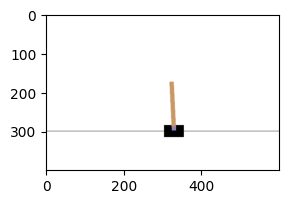

200.0

In [8]:
play(True)[-1]